In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor, Compose

import numpy as np

In [2]:
# hyperparameters
batch_size = 64
z_dim = 50
epochs = 20
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = MNIST

### MNIST reconstruction

In [3]:
dataloader = torch.utils.data.DataLoader(
    dataset('../../data', train=True, download=True,
                    transform=Compose([ToTensor()])),
    batch_size=batch_size, shuffle=True)

In [4]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, z_dim)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(z_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 28*28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = torch.reshape(self.decoder(encoded), (-1, 1, 28, 28))
        return decoded

In [5]:
ae = AutoEncoder().to(device)
ae.load_state_dict(torch.load('pre-trained/mnist/ae.pt'))

<All keys matched successfully>

In [6]:
import matplotlib.pyplot as plt

def imshow(img, save_path=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

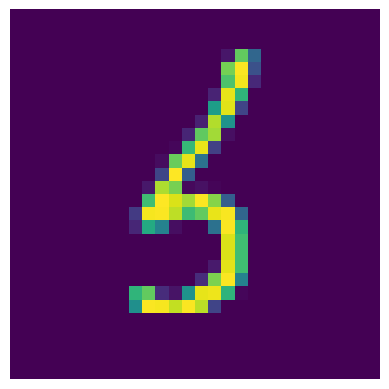

In [7]:
batch = next(iter(dataloader))
sample = batch[0][0]
imshow(sample)

In [8]:
embedding_vector = ae.encoder(sample.to(device))
embedding_vector.shape

torch.Size([1, 50])

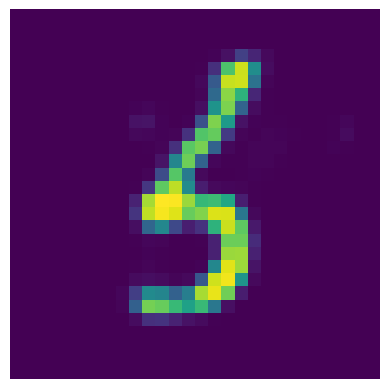

In [9]:
reconstruction = ae.decoder(embedding_vector)
reconstruction = reconstruction.reshape(1,28,28)
imshow(reconstruction.detach().to('cpu'))

In [10]:
from random import random, sample

def randomized_binary_quantization(embedding, threshold):
    binary_embedding = embedding
    binary_embedding = torch.round(binary_embedding)
    min_embedding = torch.min(binary_embedding)
    max_embedding = torch.max(binary_embedding)
    mean_embedding = torch.mean(binary_embedding)
    
    for i in range(len(binary_embedding[0])):
        if binary_embedding[0][i] < mean_embedding:
            binary_embedding[0][i] = min_embedding
            if random() < threshold:
                binary_embedding[0][i] = max_embedding
        else:
            binary_embedding[0][i] = max_embedding
            if random() < threshold:
                binary_embedding[0][i] = min_embedding

    return binary_embedding

def n_randomized_binary_quantization(embedding, n_random):
    binary_embedding = embedding
    binary_embedding = torch.round(binary_embedding)
    min_embedding = torch.min(binary_embedding)
    max_embedding = torch.max(binary_embedding)
    mean_embedding = torch.mean(binary_embedding)
    
    for i in range(len(binary_embedding[0])):
        if binary_embedding[0][i] < mean_embedding:
            binary_embedding[0][i] = min_embedding
        else:
            binary_embedding[0][i] = max_embedding

    rand_index = sample(range(len(binary_embedding[0])), n_random)
    for index in rand_index:
        if binary_embedding[0][index] == max_embedding:
            binary_embedding[0][index] = min_embedding
        else:
            binary_embedding[0][index] = max_embedding    

    return binary_embedding

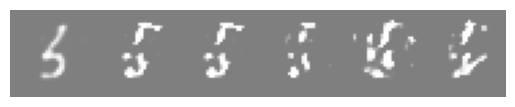

In [11]:
from torchvision.utils import make_grid

randomization_threshold = 0.05
n_random = 3

reconstructions = [ae.decoder(embedding_vector).reshape(1,28,28).to('cpu')]
for n_random in range(0, 10, 2):
    binary_embedding = randomized_binary_quantization(embedding_vector, n_random*0.01)
    reconstruction = ae.decoder(binary_embedding.to(device))
    reconstruction = reconstruction.reshape(1,28,28)
    reconstructions.append(reconstruction.detach().to('cpu'))

imshow(make_grid(reconstructions), 'reconstructions_mnist.png')

### CIFAR-10 reconstruction

In [12]:
# hyperparameters
batch_size = 64
z_dim = 50
epochs = 20
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = CIFAR10

In [13]:
dataloader = torch.utils.data.DataLoader(
    dataset('../../data', train=True, download=True,
                    transform=Compose([ToTensor()])),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [14]:
class Conv_AE(nn.Module):
    def __init__(self):
        super(Conv_AE, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
ae = Conv_AE().to(device)
ae.load_state_dict(torch.load('pre-trained/cifar/ae.pt'))

<All keys matched successfully>

In [16]:
from random import random, sample

def randomized_binary_quantization(embedding, threshold):
    binary_embedding = embedding
    binary_embedding = torch.round(binary_embedding)
    min_embedding = torch.min(binary_embedding)
    max_embedding = torch.max(binary_embedding)
    mean_embedding = torch.mean(binary_embedding)
    
    for i in range(len(binary_embedding[0])):
        
        if binary_embedding[0][i] < mean_embedding:
            binary_embedding[0][i] = min_embedding
            if random() < threshold:
                binary_embedding[0][i] = max_embedding
        else:
            binary_embedding[0][i] = max_embedding
            if random() < threshold:
                binary_embedding[0][i] = min_embedding
    
    return binary_embedding

def n_randomized_binary_quantization(embedding, n_random):
    binary_embedding = embedding
    binary_embedding = torch.round(binary_embedding)
    min_embedding = torch.min(binary_embedding)
    max_embedding = torch.max(binary_embedding)
    mean_embedding = torch.mean(binary_embedding)

    # quantization
    for i in range(len(binary_embedding[0])):
        if binary_embedding[0][i] < mean_embedding:
            binary_embedding[0][i] = min_embedding
        else:
            binary_embedding[0][i] = max_embedding

    # randomization
    rand_index = sample(range(len(binary_embedding[0])), n_random)
    for index in rand_index:
        if binary_embedding[0][index] == max_embedding:
            binary_embedding[0][index] = min_embedding
        else:
            binary_embedding[0][index] = max_embedding    

    return binary_embedding

In [17]:
batch = next(iter(dataloader))

In [18]:
samples = batch[0]
samples = samples[8:]

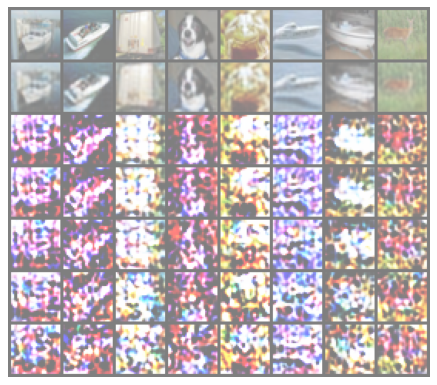

In [19]:
from torchvision.utils import make_grid

n_samples = 8
randomization_threshold = 0.05

reconstructions = []
noises = []

for i in range(n_samples):
    reconstructions.append(samples[i])

for i in range(n_samples):
    embedding = ae.encoder(samples[i].to(device))
    reconstructions.append(ae.decoder(embedding.to(device)).detach().to('cpu'))

for n_random in range(0, 5):
    for i in range(n_samples):
        embedding = ae.encoder(samples[i].to(device))
        binary_embedding = randomized_binary_quantization(embedding.reshape(1,768), n_random*randomization_threshold)
        reconstruction = ae.decoder(binary_embedding.reshape(48,4,4).to(device))
        reconstruction = reconstruction.reshape(3,32,32)
        reconstructions.append(reconstruction.detach().to('cpu'))

plt.figure(figsize=(12, 6), dpi=80)

imshow(make_grid(reconstructions, nrow=n_samples), 'reconstructions_cifar.png')

In [44]:
## Compute reconstruction error
loss = nn.MSELoss()

mean_losses = []
for i in range(7):
    cumulative_loss = 0
    for j in range(n_samples):
        cumulative_loss += loss(reconstructions[j], reconstructions[i*n_samples + j])
    mean_losses.append(cumulative_loss)
    
mean_losses

[tensor(0.),
 tensor(0.0175),
 tensor(0.7039),
 tensor(0.7687),
 tensor(0.8962),
 tensor(1.0000),
 tensor(1.1025)]

In [87]:
import pandas as pd

randomization = [0,0,0,5,10,15,20]
df = pd.DataFrame({'losses': np.array(mean_losses), 'randomization': randomization})

In [88]:
df

,losses,randomization
0,0.000000,0
1,0.017508,0
2,0.703887,0
3,0.803959,5
4,0.907490,10
5,0.981090,15
6,1.076453,20


### PACS reconstruction

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

import numpy as np

In [21]:
base_path = '/tmp/app/data/PACS/pacs_data/pacs_data/'
photos_path = f'{base_path}photo/'
art_path = f'{base_path}art_painting/'
cartoon_path = f'{base_path}cartoon/'
sketch_path = f'{base_path}sketch/'
paths = [photos_path, art_path, cartoon_path, sketch_path]

transform = Compose([ToTensor(), Resize((64,64), antialias=True)])

datasets = [ImageFolder(p, transform=transform) for p in paths]

In [22]:
concat_dataset = torch.utils.data.ConcatDataset(datasets)

In [23]:
dataloader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

In [24]:
b = next(iter(dataloader))

In [25]:
pacs_samples = [b[0][i+8] for i in range(10)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


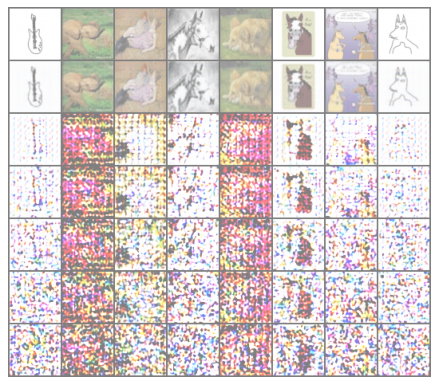

In [26]:
from torchvision.utils import make_grid

n_samples = 8
randomization_threshold = 0.05

reconstructions = []
noises = []

for i in range(n_samples):
    reconstructions.append(pacs_samples[i])

for i in range(n_samples):
    embedding = ae.encoder(pacs_samples[i].to(device))
    reconstructions.append(ae.decoder(embedding.to(device)).detach().to('cpu'))

for n_random in range(0, 5):
    for i in range(n_samples):
        embedding = ae.encoder(pacs_samples[i].to(device))
        binary_embedding = randomized_binary_quantization(embedding.reshape(1,3072), n_random*randomization_threshold)
        reconstruction = ae.decoder(binary_embedding.reshape(48,8,8).to(device))
        reconstruction = reconstruction.reshape(3,64,64)
        reconstructions.append(reconstruction.detach().to('cpu'))

plt.figure(figsize=(12, 6), dpi=80)

imshow(make_grid(reconstructions, nrow=n_samples))